In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import expit as logistic
import seaborn as sns
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

In [2]:
sns.set_color_codes()
C0, C1 = sns.color_palette()[:2]

#### Code 12.1

In [3]:
d = pd.read_csv('Data/reedfrogs.csv', sep=",")
print(d.shape)
d.head(8)

(48, 5)


,density,pred,size,surv,propsurv
0,10,no,big,9,0.9
1,10,no,big,10,1.0
2,10,no,big,7,0.7
3,10,no,big,10,1.0
4,10,no,small,9,0.9
5,10,no,small,9,0.9
6,10,no,small,10,1.0
7,10,no,small,9,0.9


#### Code 12.2

In [4]:
# make the tank cluster variable
tank = np.arange(d.shape[0])
# fit
with pm.Model() as m_12_1:
    a_tank = pm.Normal('a_tank', 0, 5, shape=d.shape[0])
    p = pm.math.invlogit(a_tank[tank])
    surv = pm.Binomial('surv', n=d.density, p=p, observed=d.surv)
    trace_12_1 = pm.sample(2000, tune=2000, njobs=4)
# pm.summary(trace_12_1, alpha=.11).round(2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 4000/4000 [00:29<00:00, 135.89it/s]


#### Code 12.3

In [5]:
with pm.Model() as m_12_2:
    a = pm.Normal('a', 0., 1.)
    sigma = pm.HalfCauchy('sigma', 1.)
    a_tank = pm.Normal('a_tank', a, sigma, shape=d.shape[0])
    p = pm.math.invlogit(a_tank[tank])
    surv = pm.Binomial('surv', n=d.density, p=p, observed=d.surv)
    trace_12_2 = pm.sample(2000, tune=2000, njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 4000/4000 [00:13<00:00, 292.83it/s]


#### Code 12.4

In [6]:
comp_df = pm.compare(traces=[trace_12_1, trace_12_2],
                     models=[m_12_1, m_12_2],
                     method='pseudo-BMA')

comp_df.loc[:,'model'] = pd.Series(['m12.1', 'm12.2'])
comp_df = comp_df.set_index('model')
comp_df

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
model,,,,,,,
m12.2,201.2,21.38,0,0.53,7.23,0,1
m12.1,201.44,22.61,0.25,0.47,9.28,4.5,1


#### Code 12.5

In [7]:
# extract PyMC3 samples
post = pm.trace_to_dataframe(trace_12_2, varnames=['a_tank'])

# compute median intercept for each tank
# also transform to probability with logistic
d.loc[:, 'propsurv_est'] = pd.Series(logistic(post.median(axis=0).values), index=d.index)

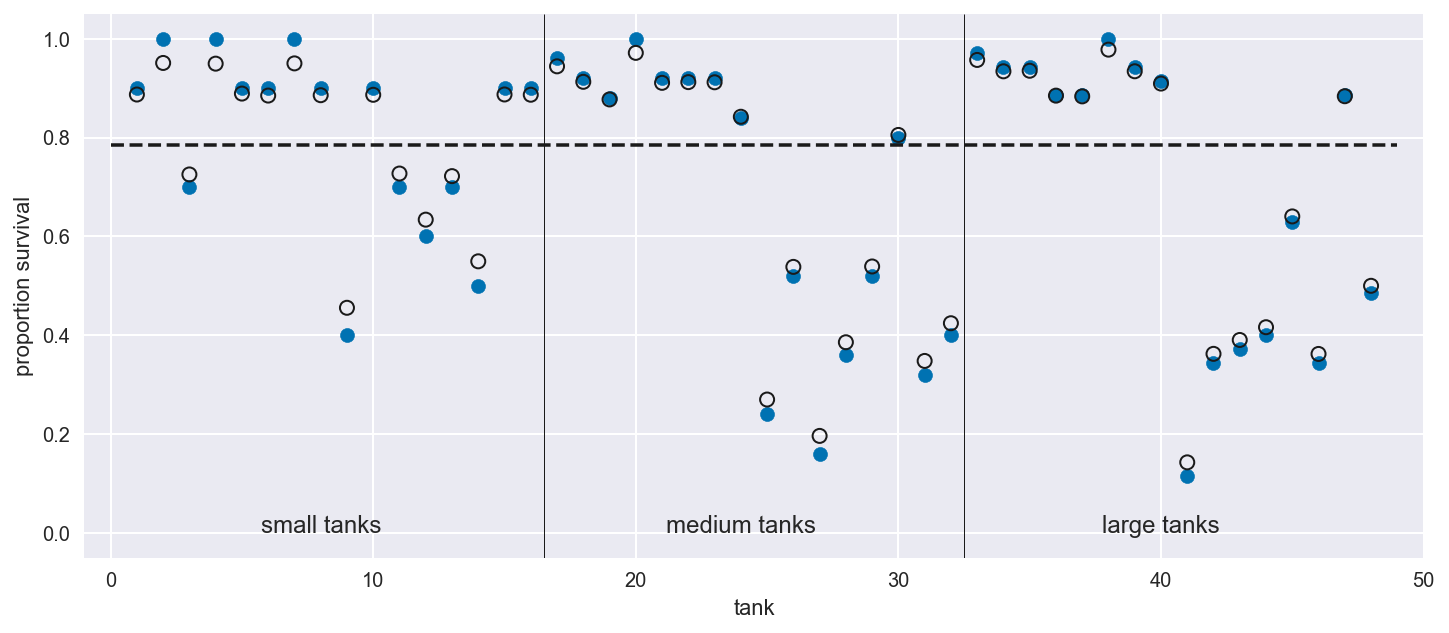

In [8]:
_, ax = plt.subplots(1, 1, figsize=(12, 5))
# display raw proportions surviving in each tank
ax.scatter(np.arange(1, 49), d.propsurv)
ax.scatter(np.arange(1, 49), d.propsurv_est,
             facecolors='none', edgecolors='k', lw=1)
ax.hlines(logistic(np.median(trace_12_2['a'], axis=0)), 0, 49, linestyles='--')
ax.vlines([16.5, 32.5], -.05, 1.05, lw=.5)
ax.text(8, 0, "small tanks", horizontalalignment='center')
ax.text(16+8, 0, "medium tanks", horizontalalignment='center')
ax.text(32+8, 0, "large tanks", horizontalalignment='center')
ax.set_xlabel('tank')
ax.set_ylabel('proportion survival')
ax.set_xlim(-1, 50)
ax.set_ylim(-.05, 1.05);

#### Code 12.6

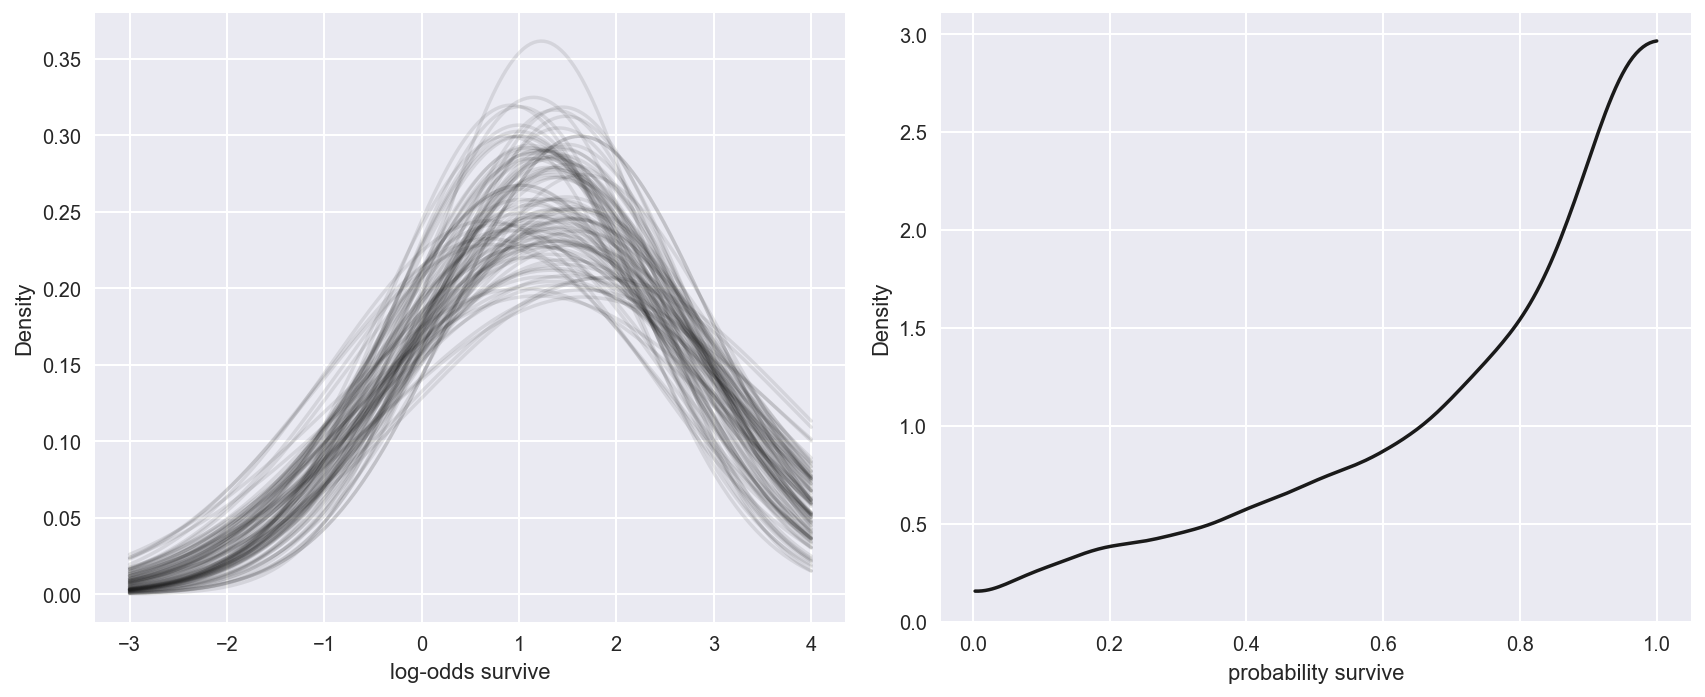

In [9]:
_, ax = plt.subplots(1, 2, figsize=(12, 5))
# show first 100 populations in the posterior
xrange = np.linspace(-3, 4, 200)
postcurve = [stats.norm.pdf(xrange, loc=trace_12_2['a'][i], scale=trace_12_2['sigma'][i]) for i in range(100)]
ax[0].plot(xrange, np.asarray(postcurve).T,
           alpha=.1, color='k')
ax[0].set_xlabel('log-odds survive')
ax[0].set_ylabel('Density');
# sample 8000 imaginary tanks from the posterior distribution
sim_tanks = np.random.normal(loc=trace_12_2['a'], scale=trace_12_2['sigma'])
# transform to probability and visualize
pm.kdeplot(logistic(sim_tanks), ax=ax[1], color='k')
ax[1].set_xlabel('probability survive')
ax[1].set_ylabel('Density')
plt.tight_layout();
# dens( logistic(sim_tanks) , xlab="probability survive" )

#### Code 12.7

In [24]:
a, sigma, nponds = 1.4, 1.5, 60
ni = np.repeat([5, 10, 25, 35], 15)

#### Code 12.8

In [25]:
a_pond = np.random.normal(loc=a, scale=sigma, size=nponds)

#### Code 12.9

In [26]:
dsim = pd.DataFrame(dict(pond=np.arange(nponds), ni=ni, true_a=a_pond))

#### Code 12.10
Data types related. Python is dynamically-typed.

#### Code 12.11

In [27]:
dsim.loc[:, 'si'] = np.random.binomial(dsim['ni'], logistic(dsim['true_a']))

#### Code 12.12

In [28]:
dsim.loc[:, 'p_nopool'] = dsim.si / dsim.ni

#### Code 12.13

In [29]:
with pm.Model() as m_12_3:
    a = pm.Normal('a', 0., 1.)
    sigma = pm.HalfCauchy('sigma', 1.)
    a_pond = pm.Normal('a_pond', a, sigma, shape=nponds)
    p = pm.math.invlogit(a_pond[dsim.pond.values])
    si = pm.Binomial('si', n=dsim.ni.values, p=p, observed=dsim.si)
    trace_12_3 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:04<00:00, 467.65it/s]


#### Code 12.14

In [30]:
summary_12_3 = pm.summary(trace_12_3, alpha=.11)
summary_12_3.iloc[[0, 1, 2, -3, -2, -1],:].round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,1.11,0.24,0.00,0.74,1.48,2000.0,1.0
a_pond__0,2.61,1.18,0.03,0.71,4.42,2000.0,1.0
a_pond__1,2.59,1.24,0.02,0.58,4.39,2000.0,1.0
a_pond__58,1.79,0.47,0.01,1.10,2.55,2000.0,1.0
a_pond__59,-0.97,0.39,0.01,-1.51,-0.25,2000.0,1.0
sigma,1.67,0.23,0.01,1.30,2.01,993.0,1.0


#### Code 12.15

In [31]:
estimated_a_pond = pm.summary(trace_12_3, alpha=.11, varnames=['a_pond'])
dsim.loc[:, 'p_partpool'] = logistic(estimated_a_pond['mean'].values)

#### Code 12.16

In [32]:
dsim.loc[:, 'p_true'] = logistic(dsim['true_a'].values)

#### Code 12.17

In [33]:
nopool_error = np.abs(dsim.p_nopool - dsim.p_true)
partpool_error = np.abs(dsim.p_partpool - dsim.p_true)

#### Code 12.18

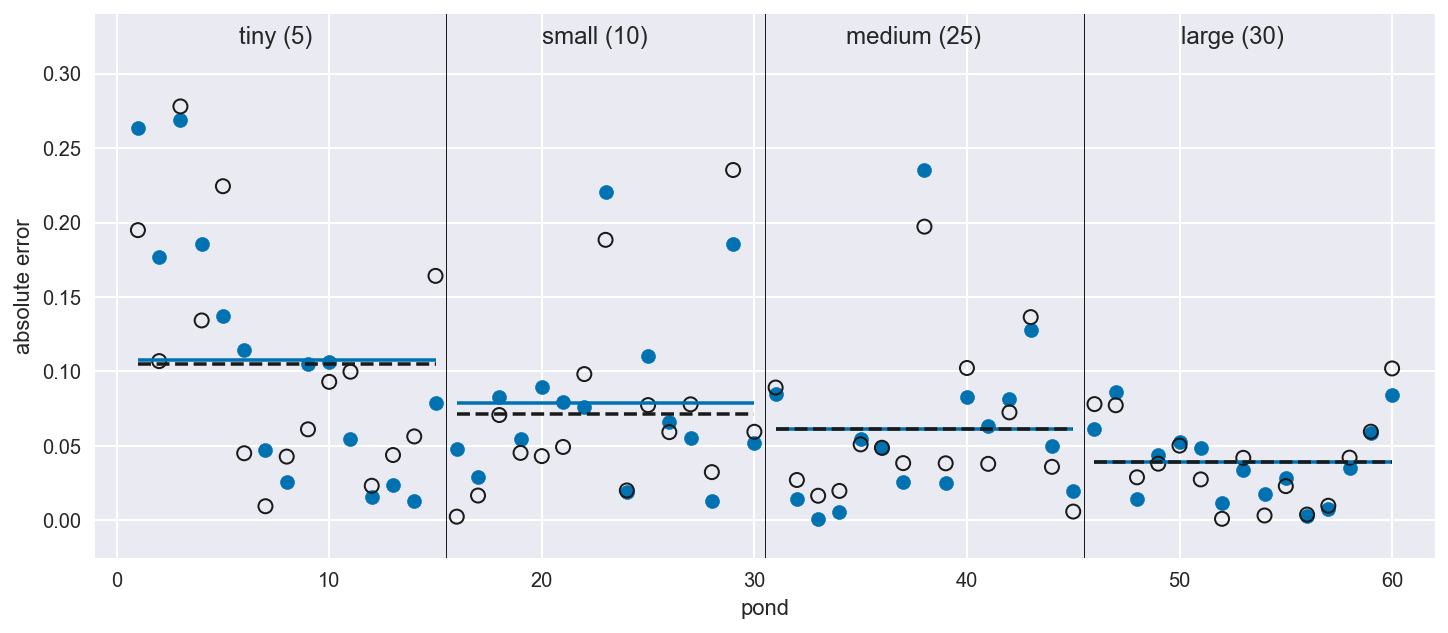

In [34]:
_, ax = plt.subplots(1, 1, figsize=(12, 5))
xrange = np.arange(60)
xrange_ = xrange.reshape((4, 15))
# display raw proportions surviving in each tank
ax.scatter(xrange+1, nopool_error)
ax.scatter(xrange+1, partpool_error,
             facecolors='none', edgecolors='k', lw=1)
ax.vlines(xrange_[1:,0]+.5, -.025, 0.35, lw=.5)

textall = ["tiny (5)", "small (10)", "medium (25)", "large (30)"]
for isem in range(4):
    ax.hlines(nopool_error[xrange_[isem, :]].mean(), 
              xrange_[isem, 0]+1, xrange_[isem, -1]+1, color=C0)
    ax.hlines(partpool_error[xrange_[isem, :]].mean(), 
              xrange_[isem, 0]+1, xrange_[isem, -1]+1, color='k', linestyles='--')
    ax.text(xrange_[isem, 7]+.5, 0.32, textall[isem], horizontalalignment='center')
ax.set_xlabel('pond')
ax.set_ylabel('absolute error')
ax.set_xlim(-1, 62)
ax.set_ylim(-.025, 0.34);

#### Code 12.19

This part is more Stan and rethinking related. To do the same in PyMC3 (i.e., avoide compiling the same model twice), you need to set up the input data with `theano.shared` or use [sampled](https://github.com/ColCarroll/sampled), a functional decorator for PyMC3.

#### Code 12.20

In [21]:
y1 = np.random.normal(10., 1., 10000)
y2 = 10. + np.random.normal(0., 1., 10000)

#### Code 12.21

In [44]:
d = pd.read_csv('Data/chimpanzees.csv', sep=";")
# we change "actor" to zero-index
d.actor = (d.actor - 1).astype(int)
Nactor = len(d.actor.unique())

with pm.Model() as model_12_4:
    bp = pm.Normal('bp', 0, 10)
    bpC = pm.Normal('bpC', 0, 10)
    
    a = pm.Normal('a', 0, 10)
    sigma_actor = pm.HalfCauchy('sigma_actor', 1.)
    a_actor = pm.Normal('a_actor', 0., sigma_actor, shape=Nactor)

    p = pm.math.invlogit(a + a_actor[d.actor.values] + (bp + bpC * d.condition) * d.prosoc_left)
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    trace_12_4 = pm.sample(5000, tune=1000, njobs=4)
# pm.traceplot(trace_12_4)
# pm.summary(trace_12_4, alpha=.11).round(2)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
100%|██████████| 6000/6000 [01:35<00:00, 63.07it/s]


#### Code 12.22

In [49]:
total_a_actor = np.asarray([trace_12_4['a'] + trace_12_4['a_actor'][:, i] for i in range(Nactor)])
total_a_actor.mean(axis=1).round(2)

array([-0.71,  4.62, -1.02, -1.02, -0.71,  0.23,  1.76])

#### Code 12.23

In [52]:
d.block = (d.block - 1).astype(int)
Nblock = len(d.block.unique())

with pm.Model() as model_12_5:
    bp = pm.Normal('bp', 0, 10)
    bpC = pm.Normal('bpC', 0, 10)
    
    a = pm.Normal('a', 0, 10)
    sigma_actor = pm.HalfCauchy('sigma_actor', 1.)
    a_actor = pm.Normal('a_actor', 0., sigma_actor, shape=Nactor)

    sigma_block = pm.HalfCauchy('sigma_block', 1.)
    a_block = pm.Normal('a_block', 0., sigma_block, shape=Nblock)
    
    p = pm.math.invlogit(a + a_actor[d.actor.values] + a_block[d.block.values]
                         + (bp + bpC * d.condition) * d.prosoc_left)
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    trace_12_5 = pm.sample(6000, tune=1000, njobs=4)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
100%|█████████▉| 6998/7000 [02:41<00:00, 46.51it/s] /Users/jlao/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 0 contains 42 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 7000/7000 [02:41<00:00, 43.38it/s]
/Users/jlao/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 1 contains 16 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
/Users/jlao/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 2 contains 3 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
/Users/jl

#### Code 12.24

In [53]:
pm.summary(trace_12_5, alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
bp,0.83,0.26,0.00,0.41,1.25,16453.0,1.0
bpC,-0.14,0.30,0.00,-0.62,0.35,18104.0,1.0
a,0.46,0.97,0.01,-1.01,1.94,4240.0,1.0
a_actor__0,-1.18,0.98,0.01,-2.63,0.33,4295.0,1.0
a_actor__1,4.20,1.70,0.02,1.80,6.47,5850.0,1.0
a_actor__2,-1.48,0.99,0.01,-3.03,-0.05,4293.0,1.0
a_actor__3,-1.48,0.98,0.01,-3.02,-0.03,4260.0,1.0
a_actor__4,-1.17,0.98,0.02,-2.66,0.31,4249.0,1.0
a_actor__5,-0.22,0.98,0.01,-1.72,1.26,4263.0,1.0
a_actor__6,1.32,1.01,0.01,-0.21,2.87,4686.0,1.0


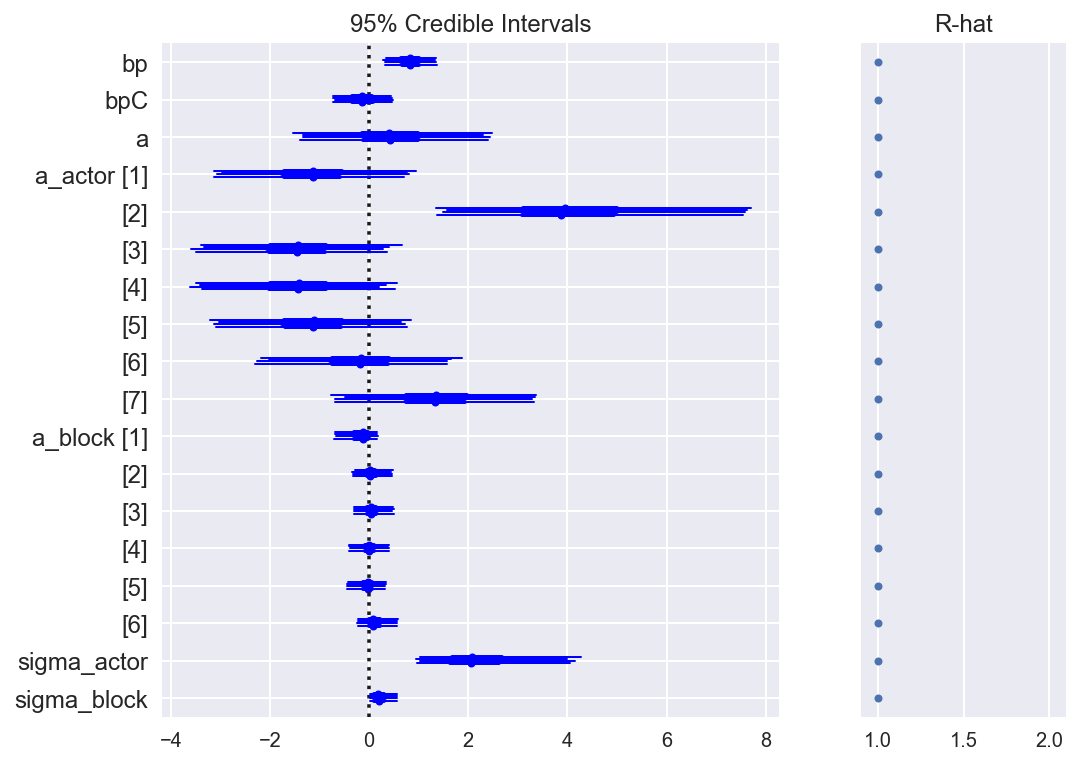

In [55]:
pm.forestplot(trace_12_5);

#### Code 12.25

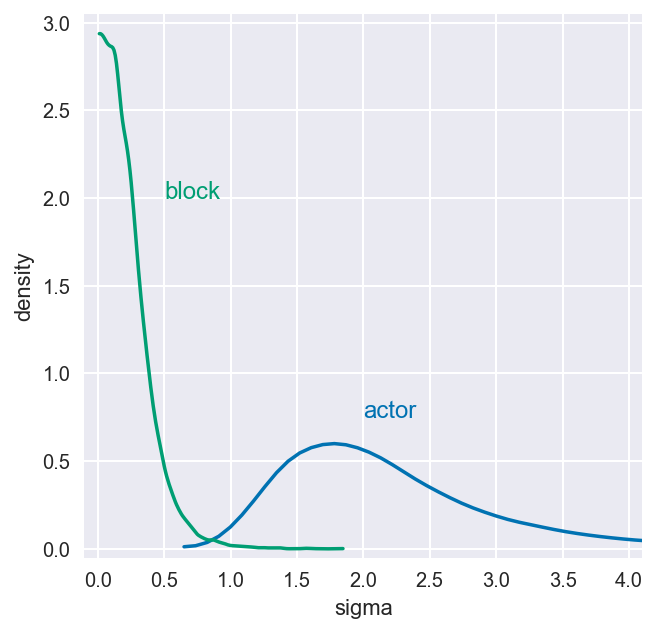

In [64]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))
pm.kdeplot(trace_12_5['sigma_actor'], ax=ax)
pm.kdeplot(trace_12_5['sigma_block'], ax=ax)
ax.text(2, 0.75, "actor", color=C0)
ax.text(0.5, 2, "block", color=C1)
ax.set_xlabel('sigma')
ax.set_ylabel('density')
ax.set_xlim(-0.1, 4.1)
ax.set_ylim(-0.05, 3.05);

#### Code 12.26

In [56]:
comp_df = pm.compare(traces=[trace_12_4, trace_12_5],
                     models=[model_12_4, model_12_5],
                     method='pseudo-BMA')

comp_df.loc[:,'model'] = pd.Series(['m12.4', 'm12.5'])
comp_df = comp_df.set_index('model')
comp_df

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
model,,,,,,,
m12.4,531.6,8.23,0,0.64,19.48,0,0
m12.5,532.8,10.48,1.19,0.36,19.68,1.78,0


#### Code 12.27

#### Code 12.28

#### Code 12.29

#### Code 12.30

#### Code 12.31

#### Code 12.32

#### Code 12.33

#### Code 12.34

#### Code 12.35

#### Code 12.36

#### Code 12.37

#### Code 12.38

#### Code 12.39

#### Code 12.40

#### Code 12.41

#### Code 12.42

#### Code 12.43

In [23]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nPandas %s\nSciPy %s\nMatplotlib %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, pd.__version__, scipy.__version__, matplotlib.__version__))

This notebook was createad on a computer x86_64 running   and using:
Python 3.5.1
IPython 6.2.1
PyMC3 3.2
NumPy 1.12.0
Pandas 0.20.2
SciPy 0.19.1
Matplotlib 2.0.2

